# 3D Sparse Reconstruction
This notebook showcases how sparse face reconstruction with the Basel Face Model can be done directly in 3D.  
The resulting optimization problem is simpler as it does not contain projecting between 3D and 2D. However, more preprocessing is necessary.  
We need RGB-D data to be able to generate a pointcloud. In this notebook, the `BIWI Kinect Dataset` is used. It can be downloaded here: https://www.kaggle.com/kmader/biwi-kinect-head-pose-database  
As depth and color channel typically are not aligned, we first have to do registration.  
Finally, we can detect the landmarks in the 2D color image, project them with the depth information to 3D and then proceed with the optimization process

In [1]:
%cd ..
%reload_ext autoreload
%autoreload 2

D:\ownCloud\Uni\Semester Ma 5\3D Scanning & Motion Capture (IN2354)\Project\3D-FaceReconstruction


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pyrender
from scipy import optimize

from face_reconstruction.data.biwi import BiwiDataLoader
from face_reconstruction.graphics import draw_pixels_to_image, register_rgb_depth, backproject_points, interpolate_around
from face_reconstruction.landmarks import load_bfm_landmarks, detect_landmarks
from face_reconstruction.model import BaselFaceModel
from face_reconstruction.optim import SparseOptimization

# 1. Face Model

In [3]:
bfm = BaselFaceModel.from_h5("model2019_face12.h5")
bfm_landmarks = load_bfm_landmarks("model2019_face12_landmarks_v2")
bfm_landmark_indices = np.array(list(bfm_landmarks.values()))

In [4]:
n_shape_coefficients = bfm.get_n_shape_coefficients()
n_expression_coefficients = bfm.get_n_expression_coefficients()
n_color_coefficients = bfm.get_n_color_coefficients()

# 2. Input RGB-D Image 

In [5]:
run_id = 1
frame_id = 4

biwi_loader = BiwiDataLoader(run_id)
frame = biwi_loader.get_frame(frame_id)

In [6]:
img_width = biwi_loader.get_image_width()
img_height = biwi_loader.get_image_height()

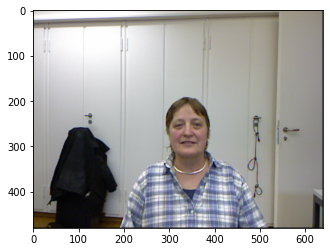

In [7]:
img = frame.get_color_image()
plt.imshow(img)

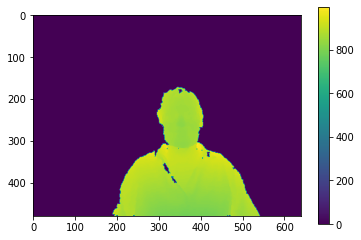

In [16]:
plt.imshow(frame.get_depth_image())
plt.colorbar()

## 2.1 Depth and RGB channels are not aligned

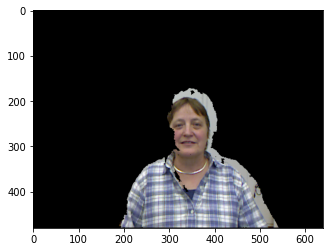

In [17]:
masked_color_image = frame.get_color_image()
masked_color_image[frame.get_depth_image() == 0] = 0
plt.imshow(masked_color_image)

## 2.2 Align Depth and RGB channels (Registration)

In [10]:
points, colors, screen_positions = register_rgb_depth(frame.get_depth_image(), frame.get_color_image(), biwi_loader.get_depth_intrinsics(), biwi_loader.get_rgb_intrinsics(), biwi_loader.get_rgb_extrinsics())

In [11]:
img_depth_mask = np.zeros((img_height, img_width))
draw_pixels_to_image(img_depth_mask, screen_positions)

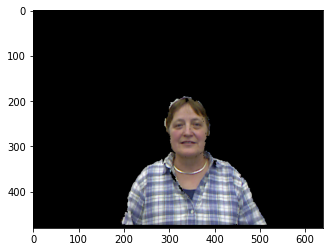

In [12]:
masked_color_image = frame.get_color_image()
masked_color_image[img_depth_mask == 0] = 0
plt.imshow(masked_color_image)
plt.show()

# 3. Render Point Cloud

In [13]:
perspective_camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
projection_matrix = perspective_camera.get_projection_matrix(width=img_width, height=img_height)
initial_camera_pose = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]) # position camera just in front of face
directional_light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=2.0)

In [14]:
points_to_render = np.array(points)
points_to_render[:, 2] = -points_to_render[:, 2]  # Invert z-coordinate for easier rendering (point cloud will be right in front of camera)

In [15]:
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_points(points_to_render, colors=colors), pose=initial_camera_pose)
scene.add(perspective_camera)
scene.add(directional_light)

In [16]:
pyrender.Viewer(scene, use_raymond_lighting=True, viewport_size=(img_width, img_height))

Viewer(width=640, height=480)

# 4. Detect 3D Landmarks

In [17]:
landmarks_img = detect_landmarks(img)

In [18]:
# Create a depth image for easier querying of depth values
rgb_depth_img = np.zeros((img_height, img_width))
for point, screen_position in zip(points, screen_positions):
    rgb_depth_img[screen_position[1], screen_position[0]] = point[2]

In [19]:
# As RGB and depth channels are not aligned, we might not have exact depth information for every pixel in the color channel. Hence, we have to interpolate
interpolation_size = 1
rgb_depth_values = [interpolate_around(rgb_depth_img, pixel, interpolation_size) for pixel in landmarks_img]

In [20]:
pixels_without_depth = sum(np.array(rgb_depth_values) == 0)
if pixels_without_depth > 0:
    print(f"There are {pixels_without_depth} pixels without depth information. Consider increasing `interpolation_size`!")

There are 3 pixels without depth information. Consider increasing `interpolation_size`!


In [21]:
valid_landmark_points_3d = np.where(np.array(rgb_depth_values) != 0)[0]

In [22]:
landmark_points_3d = backproject_points(biwi_loader.get_rgb_intrinsics(), rgb_depth_values, landmarks_img)
landmark_points_3d_render = np.array(landmark_points_3d)
landmark_points_3d_render[:,2] = -landmark_points_3d_render[:,2]  # Invert z-coordinate for easier rendering (landmarks will be right in front of camera)

In [23]:
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_points(points_to_render, colors=colors), pose=initial_camera_pose)
scene.add(pyrender.Mesh.from_points(landmark_points_3d_render[valid_landmark_points_3d], colors=[[255, 0, 0] for _ in range(len(landmark_points_3d[valid_landmark_points_3d]))]), pose=initial_camera_pose)
scene.add(perspective_camera)
scene.add(directional_light)

In [24]:
pyrender.Viewer(scene, use_raymond_lighting=True, viewport_size=(img_width, img_height))

Viewer(width=640, height=480)

# 5. Optimization

In [37]:
n_params_shape = 3 # 20
n_params_expression = 3 # 10
weight_shape_params = 1 # 10000
weight_expression_params = 1 # 1000

In [38]:
sparse_optimization = SparseOptimization(bfm, n_params_shape, n_params_expression, weight_shape_params=weight_shape_params, weight_expression_params=weight_expression_params)
loss = sparse_optimization.create_loss_3d(bfm_landmark_indices[valid_landmark_points_3d], landmark_points_3d_render[valid_landmark_points_3d])

In [39]:
initial_params = sparse_optimization.create_parameters(
    [0 for _ in range(n_shape_coefficients)],
    [0 for _ in range(n_expression_coefficients)],
    initial_camera_pose
)

# TODO: add regularization to optimization
# TODO: do dense reconstruction

In [40]:
# This typically takes 20 seconds
result = optimize.least_squares(loss, initial_params.to_theta(), max_nfev=100, verbose=2, x_scale='jac')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8460e+07                                    1.11e+06    
       1              2         2.8452e+07      7.57e+03       1.24e-01       1.11e+06    
       2              3         2.8437e+07      1.51e+04       2.48e-01       1.13e+06    
       3              4         2.8407e+07      3.03e+04       5.04e-01       1.25e+06    
       4              5         2.8345e+07      6.20e+04       1.13e+00       3.45e+06    
       5              6         2.8222e+07      1.23e+05       1.97e+00       5.90e+06    
       6              7         2.7977e+07      2.45e+05       3.93e+00       9.98e+06    
       7              8         2.7488e+07      4.89e+05       7.85e+00       1.84e+07    
       8              9         2.6506e+07      9.82e+05       1.56e+01       4.09e+07    
       9             10         2.4478e+07      2.03e+06       3.10e+01       1.24e+08    

In [41]:
params = sparse_optimization.create_parameters_from_theta(result.x)

In [42]:
face_mesh = bfm.draw_sample(
        shape_coefficients=params.shape_coefficients, 
        expression_coefficients=params.expression_coefficients, 
        color_coefficients=[0 for _ in range(n_color_coefficients)])

In [43]:
bfm_landmark_vertices = np.array(face_mesh.vertices)[bfm_landmark_indices]

In [48]:
def setup_scene(show_landmarks=True, show_pointcloud=True, show_mask=True):
    scene = pyrender.Scene()
    if show_pointcloud:
        scene.add(pyrender.Mesh.from_points(points_to_render, colors=colors), pose=initial_camera_pose)
    if show_mask:
        scene.add(pyrender.Mesh.from_trimesh(bfm.convert_to_trimesh(face_mesh)), pose=params.camera_pose)
    if show_landmarks:
        scene.add(pyrender.Mesh.from_points(landmark_points_3d_render, colors=[[255, 0, 0] for _ in range(len(landmark_points_3d))]), pose=initial_camera_pose)
        scene.add(pyrender.Mesh.from_points(bfm_landmark_vertices, colors=[[0, 255, 0] for _ in range(len(bfm_landmark_vertices))]), pose=params.camera_pose)
    scene.add(perspective_camera)
    scene.add(directional_light)
    return scene

In [53]:
scene = setup_scene(show_landmarks=True, show_pointcloud=True)

In [54]:
pyrender.Viewer(scene, use_raymond_lighting=True, viewport_size=(img_width, img_height))

Viewer(width=640, height=480)

In [55]:
r = pyrender.OffscreenRenderer(img_width, img_height)
color, depth = r.render(scene)
r.delete()

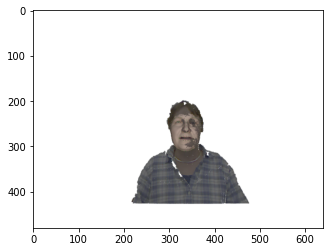

In [47]:
plt.imshow(color)